
### Project: Text Classification
**Data Set:** spam.csv located at https://www.kaggle.com/uciml/sms-spam-collection-dataset/version/1 <br>
**Note:** you might want to use `encoding of latin-1` when loading this file (https://www.kaggle.com/benvozza/spam-classification)

**Objective:** to classify SMS message as spam or not spam (ham).

From the given data set, use Naïve Bayes to classify the SMS message.
The framework for text classification is briefly summarized here:
* Transformation of your dataset(change to lower case, remove numbers, remove punctuation, stop words, white space, word stemming, etc.)
* Document-Term-Matrix creation – matrix of word counts for each individual document in the matrix (e.g. documents as rows, words as columns or vice versa)
* Text Analysis (e.g. word counts, visualizations using wordclouds)

**Helpful links:**<br>
https://machinelearningmastery.com/clean-text-machine-learning-python/ <br>
http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization <br>
https://machinelearningmastery.com/prepare-text-data-machine-learning

**Analysis Questions:**<br>
* What is the accuracy of the model?  Report your finding with corresponding
  tables/graphs.    
  *See **3.C***
* Print the 5 most frequent words in each class, and their posterior probability
  generated by the model.    
  *See **3.D***
* How would you improve the model performance?    
  *See **3.E***
* If the data set is bigger, do you think the accuracy increases? Discuss.    
  *I believe it would depend on the quality of the data (how well does it
  correlate to one category or another).  A larger data set with repeated
  words/phrases that aren't statistically significant would not help.*

---

# 1 Setup

## 1.A Sanity Check of Provided Data File

In [1]:
%%bash
declare -a DATA_FILES=("data/spam.csv")

for FILE in "${DATA_FILES[@]}"; do
    if [ -f "${FILE}" ] ; then
        echo "${FILE}:"
        echo "    Data file size:      $(du -h ${FILE} | awk '{print $1;}')"
        echo "    Data file type:      $(file --brief ${FILE})"
        echo "    Number of lines:     $(wc -l ${FILE} | awk '{print $1;}')"
        echo "    Data header row?     $(head -n 1 ${FILE})"
    else
        echo "${FILE}: NOT FOUND"
    fi
done

data/spam.csv:
    Data file size:      492K
    Data file type:      CSV text
    Number of lines:     5572
    Data header row?     v1,v2,,,


## 1.B Python/Jupyter Setup

We organize the imports at the begining of the notebook, similar to a
"traditional" Python file.  This is a personal preference.

Furthermore, we prefer the Python `logging` module over "raw" print statements
to stdout.

In [2]:
import logging
import matplotlib.pyplot as plt
import nltk.corpus
import nltk.data
import nltk.help
import nltk.stem
import nltk.tag
import nltk.tokenize
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import sklearn.compose
import sklearn.decomposition
import sklearn.feature_extraction
import sklearn.feature_selection
import sklearn.impute
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import string
import wordcloud

# Activate the 'inline' backend such that plots are displayed directly
# after the cell containing the plot command
%matplotlib inline

# Display up to 100 rows
pd.set_option('max_row', 100)

# Set up logging ...
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

LOGGER = logging.getLogger('MSDS-680')

RANDOM_SEED = 42

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1.C Import the Data

* Recall from **1.A** that the file has 5572 lines, so we expect
  `df_rows = 5572 - 1 = 5571` (because we also know the file contains a header
  row)
* Also from **1.A**, we know that there are `5` columns, based on the number
  of labels in the header row.


In [3]:
spam_df = pd.read_csv('data/spam.csv', encoding='latin-1')
LOGGER.info(f'spam_df.shape ==> {spam_df.shape[0]} rows x {spam_df.shape[1]} cols')
spam_df.head()

2022-01-30 23:14:47 - INFO   -   MSDS-680 - spam_df.shape ==> 5572 rows x 5 cols


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 1.D Setup Conclusion

The data file is successfully imported into a Pandas data frame.  We know that
we've loaded every line and we have the correct number of columns.

Beyond that, though, we cannot assume the accuracy of the content until we
perform EDA (which we are now ready for).

# 2 Exploratory Data Analysis

## 2.A Dataset Documentation
  
It appears that not all columns have data ... only the first two are labeled
(`v1`, `v2`).  According to Kaggle.com (n.d.):
          
          The files contain one message per line. Each line is composed by two
          columns: v1 contains the label (ham or spam) and v2 contains the raw
          text.

Based on the documentation, let's rename the first two columns to be more
meaningful.  Then, let's examine the `Unnamed: 2` column to see if we can
figure out what's going on...

In [4]:
spam_df.rename(columns={'v1': 'label', 'v2': 'sms'}, inplace=True)
spam_df[spam_df['Unnamed: 2'].notnull()].head()


,label,sms,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


## 2.B Concatenate Extra Columns

It appears that columns `Unnamed: 2`, `Unnamed: 3`, and `Unnamed: 4` have extra
SMS data that should have been part of the `sms` column (previously named `v2`)
but were probably interpreted as extra columns due to the confusing presence of
extra `,`s in the text content.

Below, we concatenate the extra data to the `sms` column so that we don't lose
it.

In [5]:
def merge_sms_text(row):
    ''' A user-defined function to return a new Pandas Series where the 'sms'
        column contains the concatenation of the non-null contents of
        Unnamed:2, Unnamed:3, and Unnamed:4
    '''
    sms = row['sms']
    for col in ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']:
        # The check for 'col in row' is so that this function can be executed
        # multiple times idempotently
        if col in row and type(row[col]) is str:
            sms = sms + ' ' + row[col]

    return pd.Series(data={'label': row['label'], 'sms': sms})

spam_df = spam_df.apply(merge_sms_text, axis='columns')

# When we display this row, we can see that it was concatenated successfully
# (compared to the output above, the phrase "the person is definitely..." has
# been added to the 'sms' column, whereas before it was part of the 'Unnamed: 2'
# column)
LOGGER.info(f'SMS text: {spam_df.loc[281]["sms"][:60]}...')

for k, v in spam_df['label'].value_counts().items():
    LOGGER.info(f"Counts for label '{k}': {v}")

spam_df.info()

2022-01-30 23:14:49 - INFO   -   MSDS-680 - SMS text: \Wen u miss someone  the person is definitely special for u....
2022-01-30 23:14:49 - INFO   -   MSDS-680 - Counts for label 'ham': 4825
2022-01-30 23:14:49 - INFO   -   MSDS-680 - Counts for label 'spam': 747


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## 2.C Text Transformation

### 2.C.1 Text Transformation - Experimentation

Based in part on Brownlee (2017).


In [6]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

def transform_text(content, verbose=False):
    if verbose: LOGGER.debug(f'Before: {content}')

    words = nltk.tokenize.word_tokenize(content)
    words = [w for w in words if w.isalpha()]
    words = [w.lower() for w in words]
    words = [w for w in words if not w in STOP_WORDS]
    words = [wordnet_lemmatizer.lemmatize(w) for w in words]
    content = ' '.join(words)

    if verbose: LOGGER.debug(f'After:  {content}')
    return content

_ = spam_df.head()['sms'].apply(transform_text, verbose=True)

2022-01-30 23:14:49 - DEBUG  -   MSDS-680 - Before: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
2022-01-30 23:14:50 - DEBUG  -   MSDS-680 - After:  go jurong point crazy available bugis n great world la e buffet cine got amore wat
2022-01-30 23:14:50 - DEBUG  -   MSDS-680 - Before: Ok lar... Joking wif u oni...
2022-01-30 23:14:50 - DEBUG  -   MSDS-680 - After:  ok lar joking wif u oni
2022-01-30 23:14:50 - DEBUG  -   MSDS-680 - Before: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
2022-01-30 23:14:50 - DEBUG  -   MSDS-680 - After:  free entry wkly comp win fa cup final tkts may text fa receive entry question std txt rate c apply
2022-01-30 23:14:50 - DEBUG  -   MSDS-680 - Before: U dun say so early hor... U c already then say...
2022-01-30 23:14:50 - DEBUG  -   MSDS-680 - After:  u dun say early hor u c alread

### 2.C.2 Final Text Transformation

In [7]:
spam_df['sms'] = spam_df['sms'].apply(transform_text)

## 2.D Text Analysis

The word clouds below generally show that the text processing was successful.

2022-01-30 23:14:54 - INFO   -   MSDS-680 - Word cloud for label "ham"


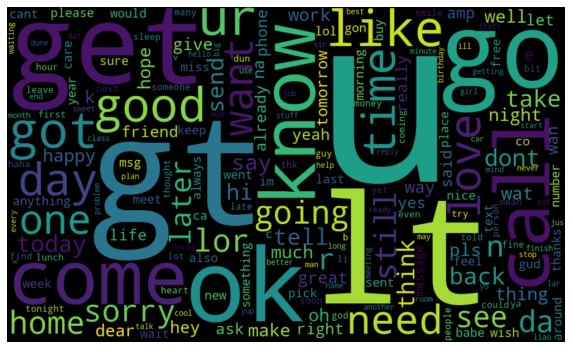

2022-01-30 23:14:55 - INFO   -   MSDS-680 - Word cloud for label "spam"


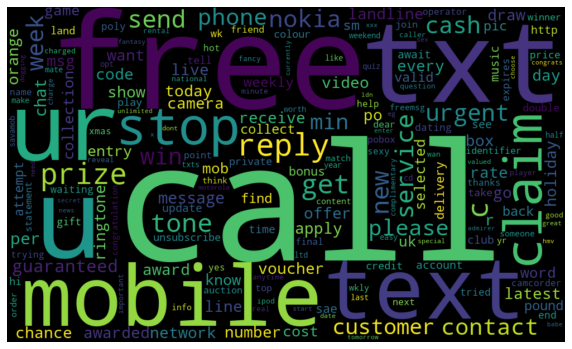

In [8]:
for label in spam_df.label.unique():
    rows    = ' '.join(spam_df[spam_df.label == label].sms)
    words   = rows.split()

    word_freq   = pd.Series(words).value_counts().to_dict()
    wc          = wordcloud.WordCloud(width=1000, height=600, max_words=200).generate_from_frequencies(word_freq)

    LOGGER.info(f'Word cloud for label "{label}"')

    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 3 Naive Bayes Classification

## 3.A Train / Test Preparation

In [9]:
# Convert text label to numerical categories
spam_df['label_num'] = spam_df['label'].apply(lambda x: 1 if x == 'spam' else 0)

label_column    = 'label_num'
feature_columns = 'sms'

# X = input, y = labels
X = spam_df[feature_columns].values
y = spam_df[label_column].values

# This will randomly split the data according to the provided ratio (0.2)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


LOGGER.info(f'X_train.shape ==> {X_train.shape[0]} rows')
LOGGER.info(f'X_test.shape  ==> {X_test.shape[0]} rows')

LOGGER.info(f'y_train.shape ==> {y_train.shape[0]} rows')
LOGGER.info(f'y_test.shape  ==> {y_test.shape[0]} rows')


2022-01-30 23:14:55 - INFO   -   MSDS-680 - X_train.shape ==> 4457 rows
2022-01-30 23:14:55 - INFO   -   MSDS-680 - X_test.shape  ==> 1115 rows
2022-01-30 23:14:55 - INFO   -   MSDS-680 - y_train.shape ==> 4457 rows
2022-01-30 23:14:55 - INFO   -   MSDS-680 - y_test.shape  ==> 1115 rows


## 3.B Create and Fit the Pipeline

In [10]:
# This pipeline contains one "translator" (TfidfVectorizer) and the
# estimator (MultinomialNB)
pipeline = sklearn.pipeline.Pipeline([
    (f'Vectorizer', sklearn.feature_extraction.text.TfidfVectorizer()),
    (f'NaiveBayes', sklearn.naive_bayes.MultinomialNB()),
])

# Pipeline.fit calls 'fit' on each transform in the pipeline and on the final
# estimator in the pipeline
#
#   - Calling 'fit' on TfidfVectorizer allows it to learn the vocabulary
#   - Calling 'fit' on MultinomialNB allows it to learn probabilities of words
#     matched to their label (spam vs ham)
#
# NOTE: TfidfVectorizer doesn't need labels, but MultinomialNB does
_ = pipeline.fit(X_train, y_train)

## 3.C Evaluate the Model

As seen below, the initial model performs very well.

Since *precision* is defined as
$\frac{Positive_{true}}{Positive_{true} + Positive_{false}}$ and we have
**no false positives**, the precision is `100%`.

On the other hand, *recall* is
$\frac{Positive_{true}}{Positive_{true} + Negative_{false}}$ and we have `38`
false negatives, the recall is only `75%`

In terms of `ham` vs `spam`, this model did not incorrectly label any `ham`
as `spam`, but it did allow `25%` of `spam` through the filter
(i.e., incorrectly labeled 38 items of `spam` as `ham`)

2022-01-30 23:14:55 - INFO   -   MSDS-680 - Using MultinomialNB ... Precision: 100.00%.  Recall: 74.67%.  F1 Score: 85.50%


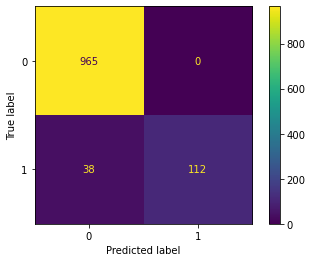

In [11]:
predicted   = pipeline.predict(X_test)

precision   = sklearn.metrics.precision_score(y_test, predicted)
recall      = sklearn.metrics.recall_score(y_test, predicted)
f1          = sklearn.metrics.f1_score(y_test, predicted)

LOGGER.info(f'Using MultinomialNB ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred=predicted)

## 3.D Word Frequency and Posterior Probabilities

### 3.D.1 Word Frequency When Class is Known

In the following analysis, we look at word frequency as though we have two
distinct sets of data, one for `ham` and one for `spam`.

With this approach, words are selected by the frequency with which they appear
in the categorized data in isolation (e.g., not taking into account if the word
also appears in the other population).

For example, the most frequently occurring word in the `spam` population is 
`call`, which appears 284 times.  Yet, $P(spam|call) = 22\%$ (we would expect a
much higher correlation).

In [12]:
X_train_ham     = np.where(y_train == 0, X_train, '')
X_train_spam    = np.where(y_train == 1, X_train, '')

for cat_name, data in [('ham', X_train_ham), ('spam', X_train_spam)]:
    counter             = sklearn.feature_extraction.text.CountVectorizer()
    count_matrix        = counter.fit_transform(data)
    vocabulary_words    = counter.get_feature_names_out()

    term_counts     = count_matrix.sum(axis=0)
    term_counts     = term_counts.A1
    sorted_indices  = list(reversed(np.argsort(term_counts)))

    for index in sorted_indices[:5]:
        word        = vocabulary_words[index]
        count       = term_counts[index]
        prob        = pipeline.predict_proba([word])
        p0, p1      = prob[0]
        cat_p       = p0 if cat_name == 'ham'  else p1

        LOGGER.info(f'P("{cat_name}"|"{word}") = {cat_p:.2%} ("{word}" appears {count} times in the "{cat_name}" sample.)')


2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"lt") = 99.46% ("lt" appears 267 times in the "ham" sample.)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"gt") = 99.46% ("gt" appears 267 times in the "ham" sample.)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"get") = 93.85% ("get" appears 242 times in the "ham" sample.)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"go") = 96.59% ("go" appears 233 times in the "ham" sample.)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"ok") = 99.21% ("ok" appears 211 times in the "ham" sample.)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("spam"|"call") = 20.20% ("call" appears 284 times in the "spam" sample.)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("spam"|"free") = 42.28% ("free" appears 180 times in the "spam" sample.)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("spam"|"txt") = 64.63% ("txt" appears 128 times in the "spam" sample.)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("spam"|"ur") = 12.60% ("ur" appe

### 3.D.2 Word Frequency When Class is Inferred

In this approach, we look at word counts across the entire data set
(regardless of the given label), then examine the probability that the word
is associated with one class or another according to the model.

This view shows us that `call` actually appears 483 times throughout the entire
data set and has a higher association with `ham` than with `spam`!

In [13]:
counter             = sklearn.feature_extraction.text.CountVectorizer()
count_matrix        = counter.fit_transform(X_train)
vocabulary_words    = counter.get_feature_names_out()

term_counts     = count_matrix.sum(axis=0)
term_counts     = term_counts.A1
sorted_indices  = reversed(np.argsort(term_counts))

counts = {'ham': 0, 'spam': 0}
for index in sorted_indices:
    word        = vocabulary_words[index]
    count       = term_counts[index]
    prob        = pipeline.predict_proba([word])
    p0, p1      = prob[0]
    cat_name    = "ham" if p0 > p1 else "spam"
    cat_p       = p0 if p0 > p1 else p1

    counts[cat_name] = counts[cat_name] + 1
    if counts[cat_name] <=5:
        LOGGER.info(f'P("{cat_name}"|"{word}") = {cat_p:.2%} ("{word}" appears {count} times in the corpus)')
    
    if counts['ham'] > 5 and counts['spam'] > 5:
        break

2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"call") = 79.80% ("call" appears 483 times in the corpus)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"ur") = 87.40% ("ur" appears 320 times in the corpus)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"get") = 93.85% ("get" appears 314 times in the corpus)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"lt") = 99.46% ("lt" appears 267 times in the corpus)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("ham"|"gt") = 99.46% ("gt" appears 267 times in the corpus)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("spam"|"txt") = 64.63% ("txt" appears 141 times in the corpus)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("spam"|"mobile") = 64.45% ("mobile" appears 123 times in the corpus)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("spam"|"claim") = 87.67% ("claim" appears 96 times in the corpus)
2022-01-30 23:14:56 - INFO   -   MSDS-680 - P("spam"|"prize") = 86.73% ("prize" appears 75 times in the corpus)
2022-01-30 23:14

## 3.E Model Improvement

### 3.E.1 Find "Strongest" Features

Inspired by Di Pietro (2020), we evaluate $\tilde{\chi}^2$ for each feature
(vocabulary word) to attempt to "weed out" irrelevant words

In [14]:
Xt_train = pipeline.named_steps['Vectorizer'].transform(X_train)

vocabulary_words    = pipeline.named_steps['Vectorizer'].get_feature_names_out()

chi2, p = sklearn.feature_selection.chi2(Xt_train, y_train)

chi2_df = pd.DataFrame({ 'feature': vocabulary_words, 'chi2': chi2, 'p': p })
    
# The value of 0.5 was chosen to keep the top 75th percentile of chi2 scores
hi_chi2_df = chi2_df[chi2_df.chi2 > 0.5].sort_values('chi2', ascending=False)
LOGGER.info(f'Alternate vocabulary size: {hi_chi2_df.shape[0]} (previously {chi2_df.shape[0]}, reduced by {1 - (hi_chi2_df.shape[0] / chi2_df.shape[0]):.2%})')
hi_chi2_df

2022-01-30 23:14:56 - INFO   -   MSDS-680 - Alternate vocabulary size: 1440 (previously 5959, reduced by 75.83%)


,feature,chi2,p
936,claim,146.220241,1.161966e-33
3970,prize,133.890947,5.772043e-31
1963,free,132.510215,1.157098e-30
5411,txt,130.162889,3.774936e-30
3248,mobile,126.045489,3.005153e-29
...,...,...,...
1670,even,0.502009,4.786188e-01
2781,knew,0.501678,4.787637e-01
1026,complete,0.501115,4.790107e-01
3350,nah,0.500935,4.790898e-01


### 3.E.2 Evaluate Model Using Reduced Features

As seen below, the reduced features produce a model that has slightly worse
precision (`98%`), but slightly better recall (`81%`).

In other words, this model did incorrectly labeled `2%` of `ham`
as `spam`, but allowed less `spam` through the filter than the previous model
(`19%` vs `25%`).


2022-01-30 23:14:56 - INFO   -   MSDS-680 - Using reduced vocabulary ... Precision: 97.60%.  Recall: 81.33%.  F1 Score: 88.73%


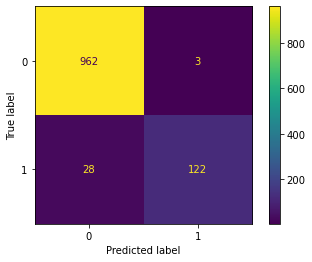

In [15]:
# Note the use of the vocabulary words from the hi_chi2_df!
pipeline = sklearn.pipeline.Pipeline([
    (f'Vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(vocabulary=hi_chi2_df.feature)),
    (f'NaiveBayes', sklearn.naive_bayes.MultinomialNB()),
])

_ = pipeline.fit(X_train, y_train)

predicted = pipeline.predict(X_test)

precision   = sklearn.metrics.precision_score(y_test, predicted)
recall      = sklearn.metrics.recall_score(y_test, predicted)
f1          = sklearn.metrics.f1_score(y_test, predicted)

LOGGER.info(f'Using reduced vocabulary ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred=predicted)

# Appendix 1: Exploration of TfidfVectorizer

*This appendix was just an attempt to better understand what was happening with the TfidfVectorizer*

After training, the `vocabulary_` attribute of the TfidfVectorizer will have
a dictionary of words from the corpus (the rows of `spam_df`) mapped to a
feature column.  The feature columns are like the examples from the exercise
(e.g., Gender, Car Type, etc.) *but* the columns are sparsely populated
because of the distribution of words across each SMS message.

In [16]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()
_ = tfidf.fit(X_train)

LOGGER.info(f'Vocabulary size: {len(tfidf.vocabulary_)}')
for k, v in random.choices(list(tfidf.vocabulary_.items()), k=5):
    LOGGER.info(f'Key "{k}" is feature #{v}')


2022-01-30 23:14:57 - INFO   -   MSDS-680 - Vocabulary size: 5959
2022-01-30 23:14:57 - INFO   -   MSDS-680 - Key "thinl" is feature #5202
2022-01-30 23:14:57 - INFO   -   MSDS-680 - Key "mummy" is feature #3321
2022-01-30 23:14:57 - INFO   -   MSDS-680 - Key "cooky" is feature #1088
2022-01-30 23:14:57 - INFO   -   MSDS-680 - Key "stopped" is feature #4921
2022-01-30 23:14:57 - INFO   -   MSDS-680 - Key "theacusations" is feature #5177


Transforming the data yields a sparse matrix with a row for each row from the
training data and an indicator in the feature column indicating whether the
vocabulary word appears in the row.

In [17]:
Xt_train - tfidf.transform(X_train)

LOGGER.info(f'Transformed data is a sparse matrix of size {Xt_train.shape[0]} rows by {Xt_train.shape[1]} cols [{type(Xt_train)}]')


2022-01-30 23:14:57 - INFO   -   MSDS-680 - Transformed data is a sparse matrix of size 4457 rows by 5959 cols [<class 'scipy.sparse.csr.csr_matrix'>]


Below, we can visualize the sparse matrix

Text(0.5, 1.0, 'TFIDF Sparse Matrix')

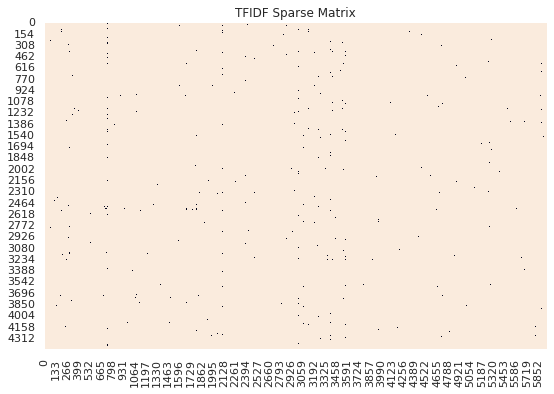

In [18]:
# Based in part on Di Pietro (2020)
sns.set(rc={ 'figure.figsize': (9, 6) })
plot = sns.heatmap(Xt_train.todense() == 0, cbar=False)
plot.set_title('TFIDF Sparse Matrix')



# References

Brownlee, J. (2017, October).  How to clean text for machine learning with
Python.  Retrieved from https://machinelearningmastery.com/clean-text-machine-learning-python/

Di Pietro, M.  (2020, July).  Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT
Preprocessing, Model Design, Evaluation, Explainability for Bag-of-Words, Word Embedding, Language models.  Retrieved from https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

Kaggle.com (n.d.)  SMS spam collection dataset.  Retrieved from
https://www.kaggle.com/uciml/sms-spam-collection-dataset/version/1

